<h3> Usefull Python libraries </h3>

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import qutip as qt
import pandas as pd
from tqdm.notebook import tqdm
from itertools import product
from scipy.stats import uniform_direction
from scipy.optimize import curve_fit
resol = 300

<h3> Functions from the gap_tools_ed library </h3>

In [47]:
from  gap_tools_ed.specific_fct.annealing_time import annealing_time
from gap_tools_ed.specific_fct.hamiltonian import hamiltonian
from gap_tools_ed.specific_fct.evolve_state import evolve_state
from gap_tools_ed.specific_fct.get_control_function import get_control_function
from gap_tools_ed.specific_fct.gap import gap, spectrum

<h1> Generate Hamiltonian </h1>

The function generate_signal returns the matrix of the received signal Y given: 
- An activity pattern
- A pilot matrix
- A level of AWGN at the AP
- A number of antenna

The function get_couplings returns the couplings $J_{ij}$ and the local fields $b_i$ allowing to build the Ising Hamiltonian associated to the problem instance $(P, Y)$. Recall that they are given by:

$$\begin{dcases}
    b_i &= - \text{Tr}\left(\bm{p}_i \bm{p}_i^H \hat{\bm{\Sigma}}_Y\right) + \frac{1}{2} \sum_{j=1}^N |\bm{p}_i^H \bm{p}_j|^2\\
    J_{ij} &= -\frac{1}{2} |\bm{p}_i^H \bm{p}_j|^2
    \end{dcases}$$

In [48]:
def generate_signal(alpha, P, xi, K):
    """
    Generates the signal matrix Y given the required parameters.

    Parameters
    ----------
    alpha : numpy array
        Activity pattern
    P : numpy array
        Pilot matrix
    xi : float
        Level of noise at the AP
    K : int
        Number of antennas

    Returns
    -------
    Y : numpy array
        Signal matrix
    """

    M, N = P.shape
    Z = np.random.normal(0, xi, (M,K))
    H_tilde = np.random.normal(0, 1, (N,K))

    alpha_diag = np.diag(alpha)
    signal = P @ alpha_diag @ H_tilde + Z

    return signal

def get_couplings(Y, P):
    """
    Computes the couplings J and b for the Ising model.

    Parameters
    ----------
    Y : numpy array
        Signal matrix
    P : numpy array
        Pilot matrix
    
    Returns
    -------
    J : numpy array
        Couplings
    b : numpy array
        Local fields
    """

    M,K = Y.shape
    N = P.shape[1]

    J = np.zeros((N,N))
    b = np.zeros(N)

    projectors_list = np.zeros((N,M,M))
    for i in range(N):
        p_vector = np.matrix(P[:,i]).T
        projectors_list[i] = p_vector @ p_vector.T

    sampled_cov = 1/K * Y @ np.conjugate(Y.T)
    
    for i in range(N):
        for j in range(i+1, N):
            J[i,j] = -1/2 * np.trace(projectors_list[i] @ projectors_list[j])

    for i in range(N):
        b[i] = - np.trace(projectors_list[i] @ sampled_cov)
        for j in range(N):
           b[i] += 1/2* np.trace(projectors_list[i] @ projectors_list[j])

    return J, b

<h1> Test the functions </h1>

<h3> Generate a problem instance </h3>

In [49]:
N = 5           # if this parameter is changed, make sure to change alpha vector (activity pattern) as well. It has to have N entries!
M = 4
K = 100
xi = 0 #thermal noise at the BS

P = np.zeros((M,N))
for i in range(N):
    P[:,i] = uniform_direction.rvs(M)
    

alpha = np.array([1,0,0,0,0])
Y = generate_signal(alpha, P, xi, K)

print("Received signal:")
print(f"shape: {np.shape(Y)}")
#print(Y)
print("-----------------")
J, b = get_couplings(Y, P)
print("Couplings:")
print(J)
print("Fields:")
print(b)

Received signal:
shape: (4, 100)
-----------------
Couplings:
[[ 0.00000000e+00 -3.79720479e-01 -2.33547145e-02 -3.08765189e-04
  -1.81006594e-02]
 [ 0.00000000e+00  0.00000000e+00 -2.59966694e-02 -5.08888396e-03
  -7.86590734e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.49650700e-01
  -7.56699224e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.32981519e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
Fields:
[-0.29954812 -0.01570965  0.64196842  0.88727584  0.70766585]


<h3> Fix parameters </h3>

In [50]:
nb_pts_gap = 20 #number of points for the gap computation
nb_pts_time = 30 #number of points for resolution of the time dependant Schrodinger's equation
epsilon = 0.1 #precision level for the control function
gamma = 1 #strength of the transverse field, irrelevant for us 

<h3> Compute the gap at some points </h3>

In [51]:
#use the control function as affine parameter
up = np.linspace(1,0,nb_pts_gap) 
tp_linear = np.linspace(0,1,nb_pts_gap)
times_tab_linear = np.linspace(0,1,nb_pts_gap)

Hlinear = hamiltonian(J,b,gamma,times_tab_linear, tp_linear, up)

#get the spectrum
spectrum_tab = spectrum(Hlinear, times_tab_linear)

#get the gap
gap_tab = spectrum_tab[:,1] - spectrum_tab[:,0]
squared_gap = gap_tab**2 

  0%|          | 0/20 [00:00<?, ?it/s]

Plot the result

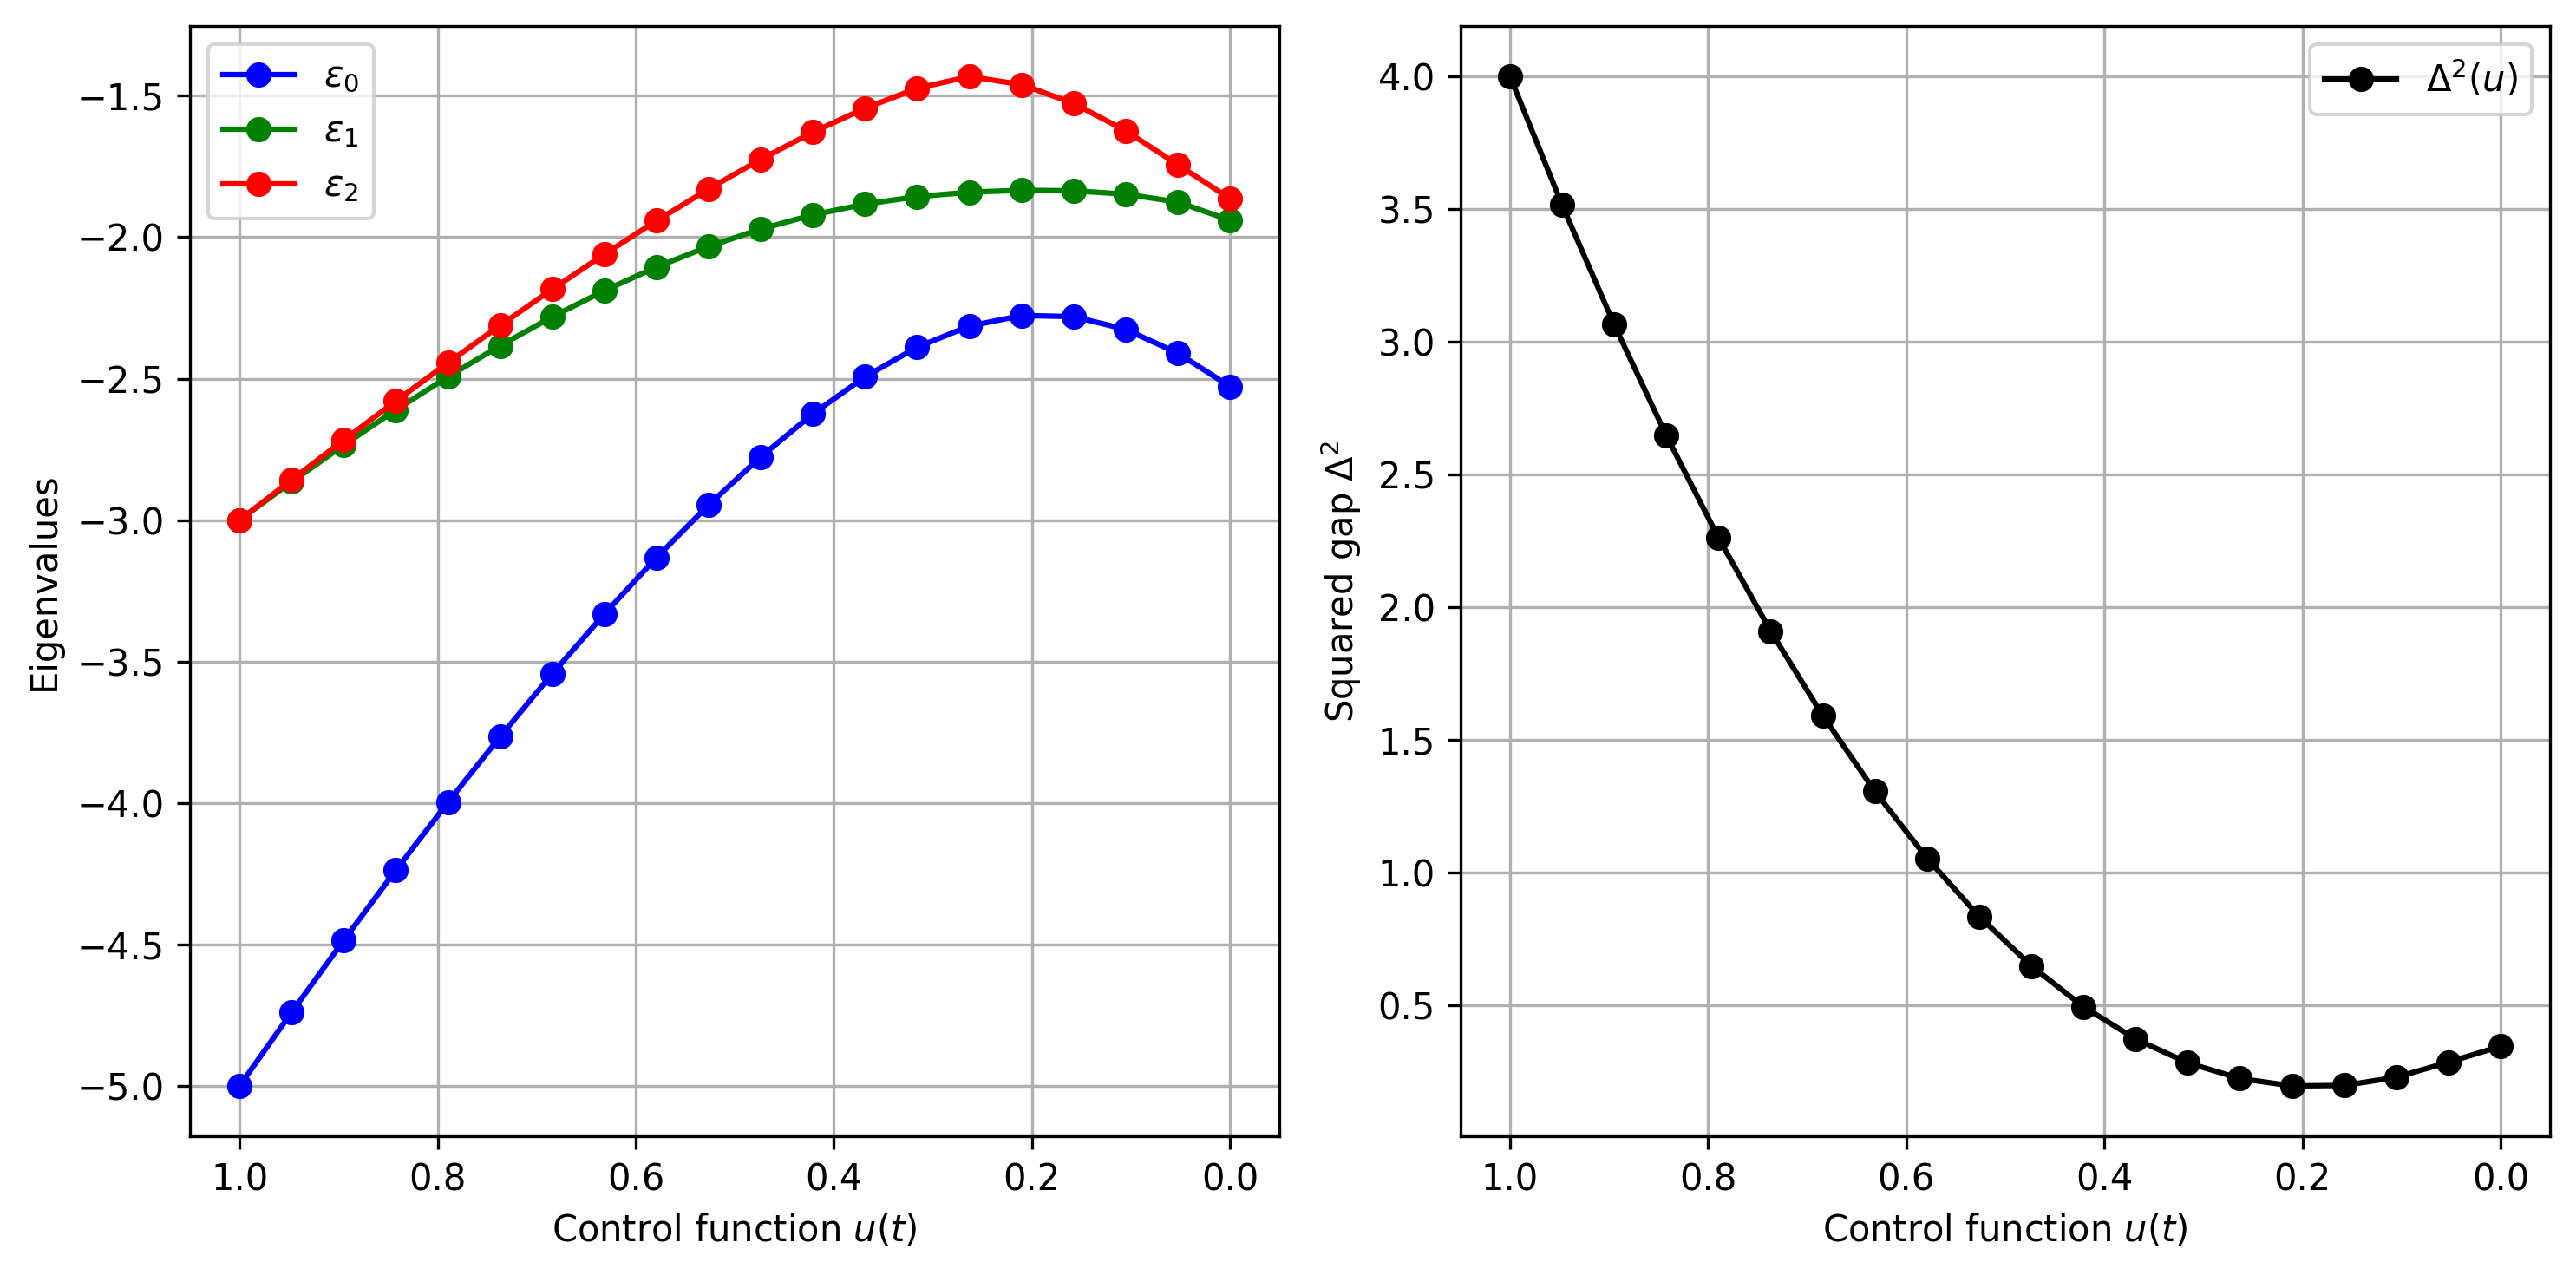

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=resol)

ax[0].plot(up, spectrum_tab[:,0], marker='o', label="$\\varepsilon_0$", color="blue")
ax[0].plot(up, spectrum_tab[:,1], marker='o', label="$\\varepsilon_1$", color="green")
ax[0].plot(up, spectrum_tab[:,2], marker='o', label="$\\varepsilon_2$", color="red")
ax[0].set_xlabel("Control function $u(t)$")
ax[0].set_ylabel("Eigenvalues")
ax[0].invert_xaxis()
ax[0].legend()
ax[0].grid()

ax[1].plot(up, squared_gap, marker='o', label="$\\Delta^2(u)$", color="black")
ax[1].set_xlabel("Control function $u(t)$")
ax[1].set_ylabel("Squared gap $\\Delta^2$")
ax[1].invert_xaxis()
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

<h3> Deduce the control function </h3>

This cell computes the control function and plots the result

Tint = 20.71839730404818, Tlin = 51.04238460508815


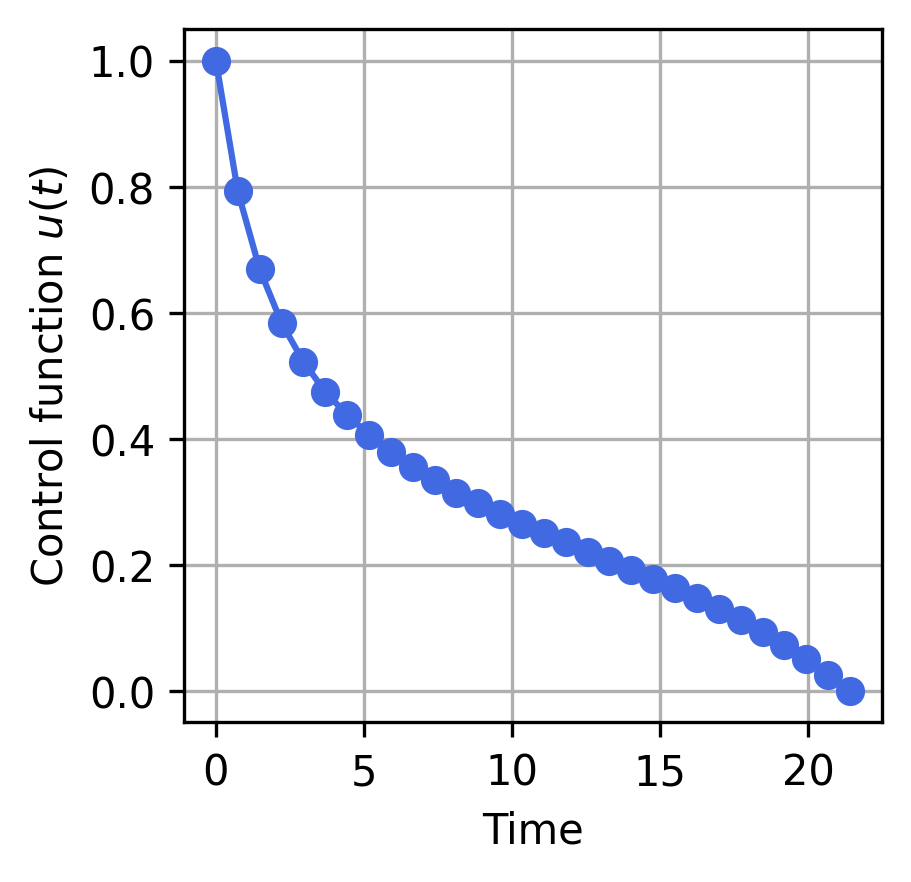

In [53]:
###Control function
tp = get_control_function(up, squared_gap, epsilon)

Tint, Tlin = annealing_time(up, gap_tab, epsilon)
print(f"Tint = {Tint}, Tlin = {Tlin}")

def control_fct(t):
    return np.interp(t, tp, up)

times_tab = np.linspace(0,tp[-1],nb_pts_time)

plt.figure(figsize=(3,3), dpi=resol)
plt.plot(times_tab, control_fct(times_tab), marker='o', color="royalblue")
plt.xlabel("Time")
plt.ylabel("Control function $u(t)$")
plt.grid()
plt.show()

<h3> Solve the Schrodinger's equation </h3>

Now that the control function is known, we can solve the time dependant Schrodinger's equation:

$$ i \hbar \partial_t \ket{\Psi(t)} = H(u(t)) \ket{\Psi(t)} $$

In [54]:
##initial state 
state_list = [(qt.basis(2, 0) + qt.basis(2,1))/np.sqrt(2)]*N
psi0 = qt.tensor(state_list)

#Hamiltonian properly defined with the control function
Hscheduled = hamiltonian(J,b,gamma,times_tab, tp, up)

proba_coef, sigma_z_exp, basis = evolve_state(Hscheduled, times_tab, psi0)

#treat the data
mean_sigmaz = np.zeros((N, nb_pts_time))
for i in range(N):
    mean_sigmaz[i] = np.real(sigma_z_exp[i])

overlap = proba_coef[0]

Evolution of the overlap between the current state and the target state

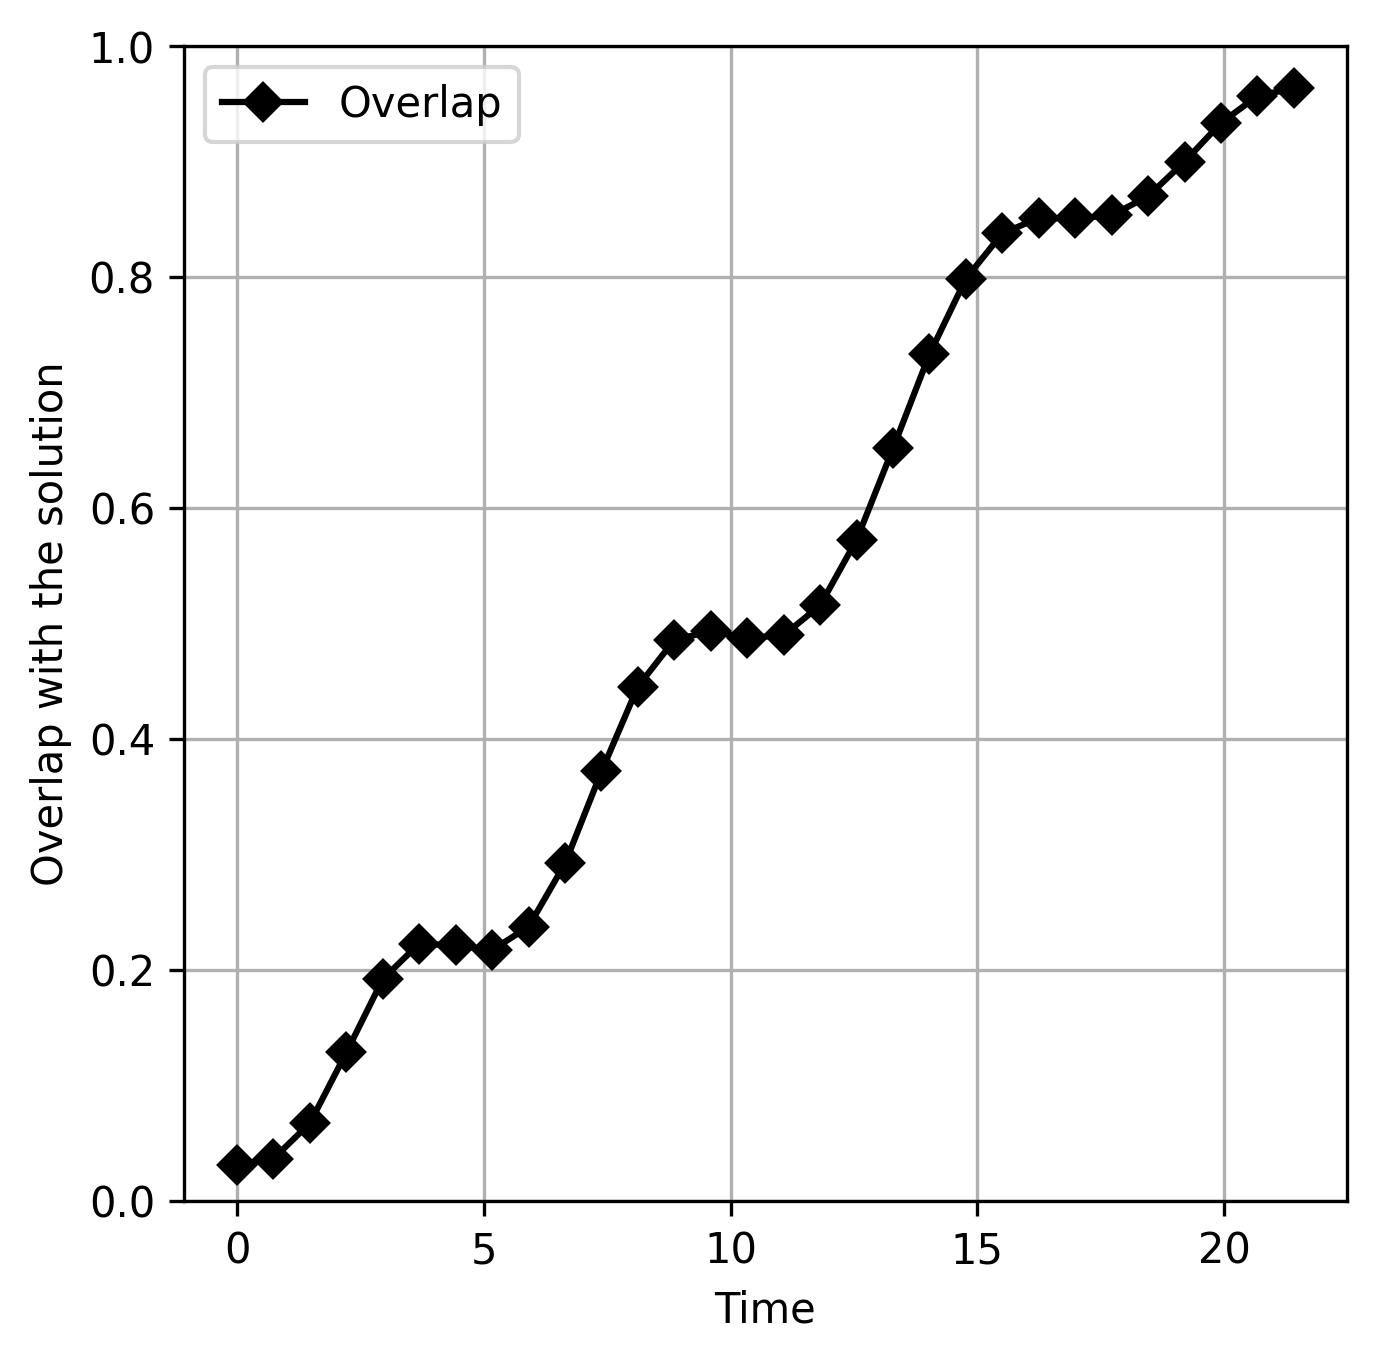

In [55]:
plt.figure(figsize=(5,5), dpi=resol)
plt.plot(times_tab, overlap, marker="D", label="Overlap", color="black")
plt.xlabel("Time")
plt.ylabel("Overlap with the solution")
plt.ylim(0,1)
plt.legend(loc="upper left")
plt.grid()
plt.show()

<h3> Final distribution </h3>

Finally, we can check the amplitudes in the final states

Ground state of the final Hamiltonian: 10000
The initial activity pattern is [1 0 0 0 0]


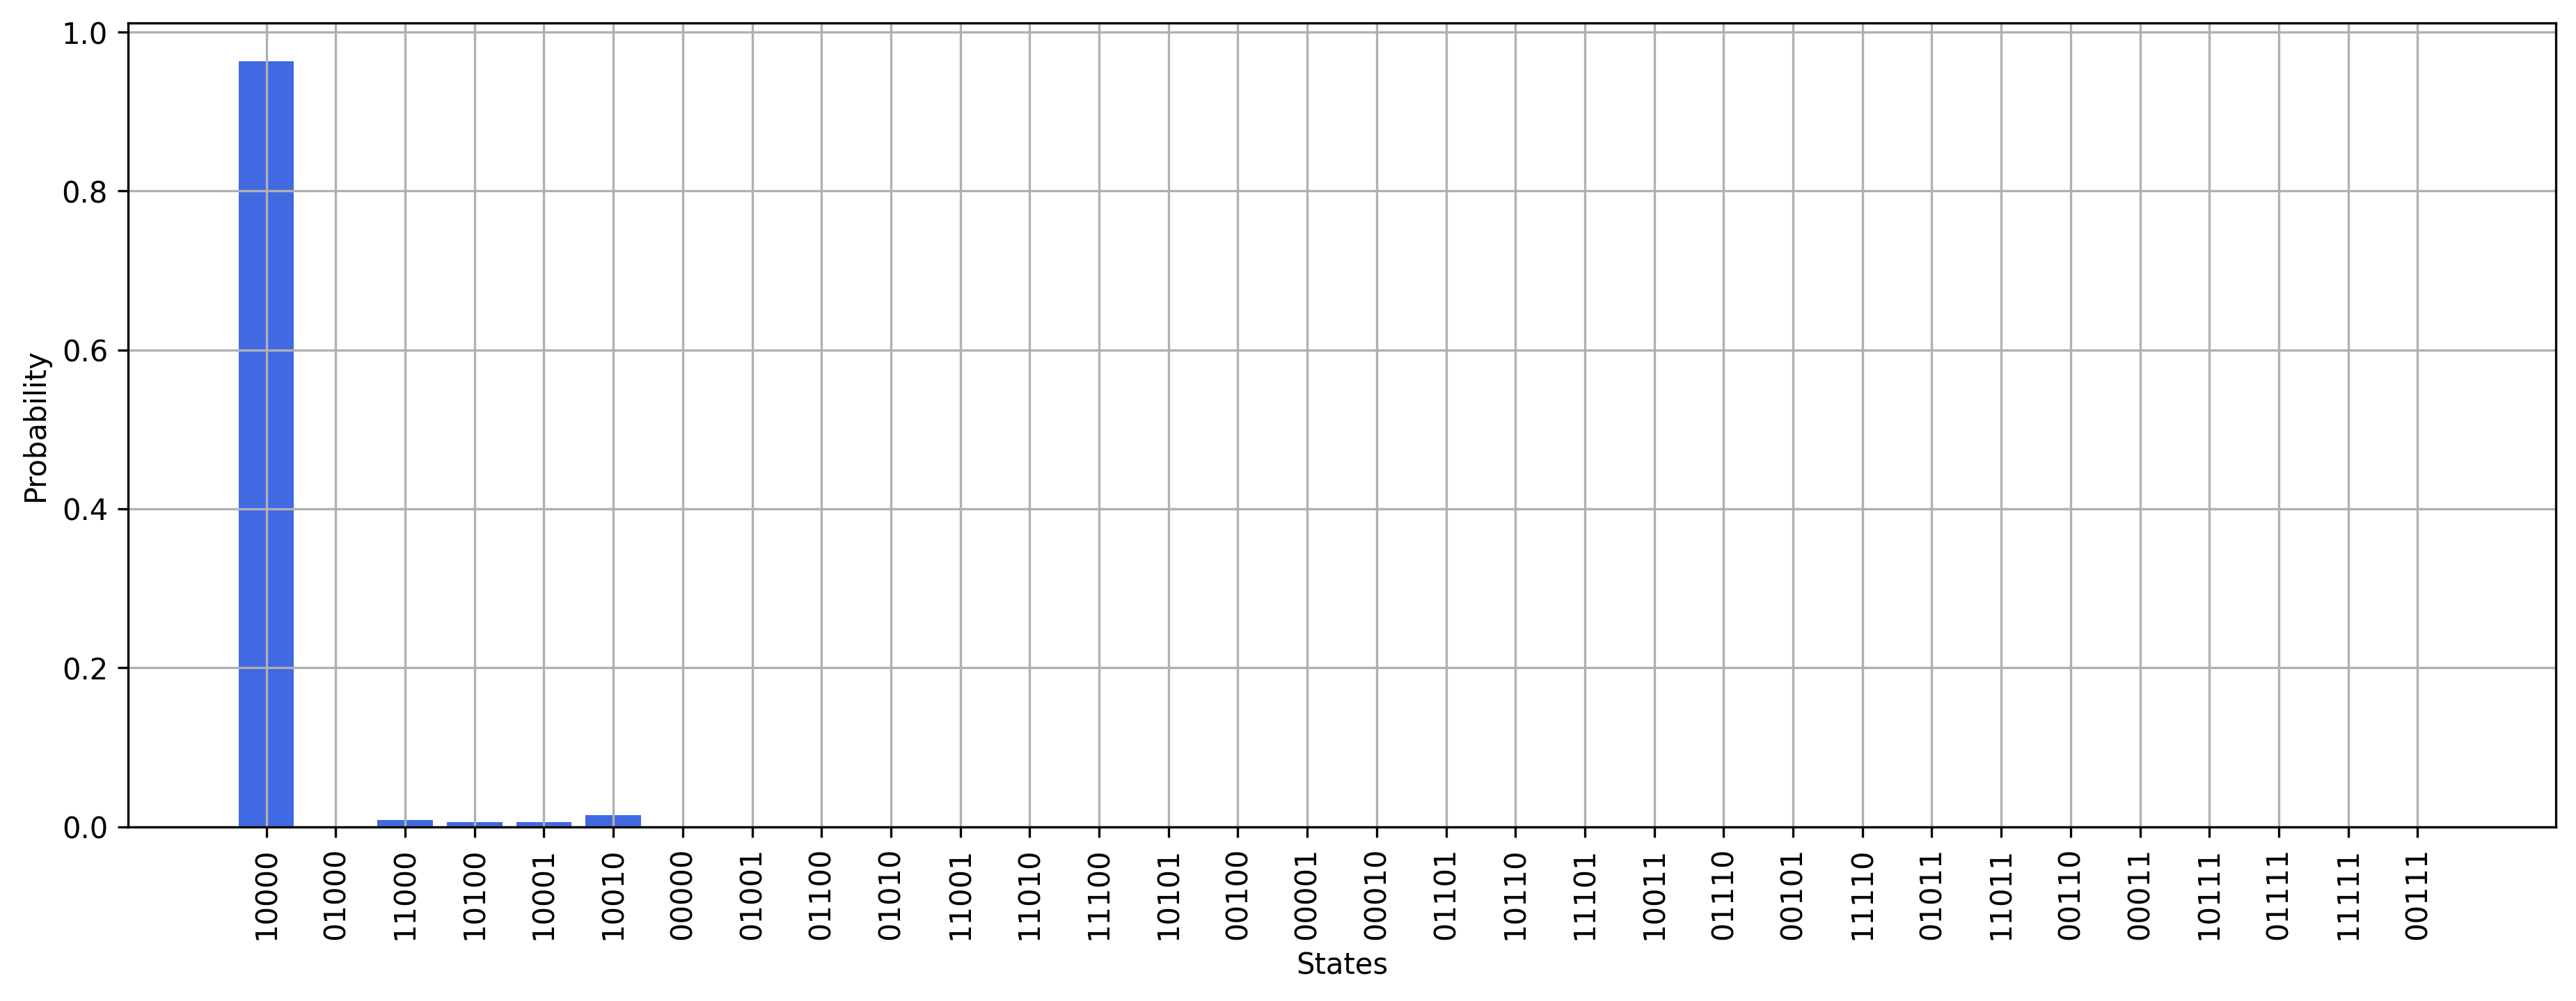

0.9999999999999999


In [56]:
#list of labels
states_string = list(product([0,1], repeat = N))
states_string = ["".join([str(i) for i in state]) for state in states_string]
xlabels = states_string.copy()
coef_to_plot = np.zeros(2**N)

for i in range(2**N):
    current_state = np.real(basis[i].full().reshape(2**N))  # without .full(), .reshape() doesn't work. full() adds an imaginary part of 0j to every number
    index_state = np.where(np.abs(current_state) > 0.99)[0][0]
    xlabels[i] = states_string[index_state]
    coef_to_plot[i] = proba_coef[i][-1]

#get the GS of the final Hamiltonian
ground_state = Hlinear(1).groundstate()[1]
idx = np.argmax(np.abs(ground_state.full()))
gs_string = states_string[idx]
print("Ground state of the final Hamiltonian:", gs_string)
print("The initial activity pattern is" , alpha)


plt.figure(figsize=(15, 5), dpi=resol)
plt.bar(xlabels, coef_to_plot, color="royalblue")
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Probability")
plt.grid()
plt.show()

print(np.sum(coef_to_plot))